# Data Loading and Preprocessing:

We start by importing essential libraries and loading the three datasets:

*   EMS data: Contains information about emergency medical services stations.
*   Hospital data: Includes details about hospitals in the region.
*   Hurricane data: Provides hurricane risk information for different counties.

We then perform a data integrity check by identifying and counting missing values in each dataset. Any rows with missing values are removed from the data in order to maintain data reliability for the analysis.

In [1]:
# Import required libraries
from ast import Param
import pandas as pd
from gurobipy import Model, GRB, quicksum
import numpy as np
import math

In [2]:
ems_data = pd.read_csv('EMS_Dataset_Final1.csv')
hospital_data = pd.read_csv("Hospital_Dataset_Final1.csv")
hurricane_data = pd.read_csv("Hurican_dataset.csv")

nan_counts = ems_data.isna().sum()
print(nan_counts)
print("-"*30)
nan_counts = hospital_data.isna().sum()
print(nan_counts)
print("-"*30)
nan_counts = hurricane_data.isna().sum()
print(nan_counts)
ems_data=ems_data.dropna()

Unnamed: 0              0
Name                    0
Address                 0
City                    0
Zip                     0
COUNTY                  0
X                       0
Y                       0
LONGLAT                 0
Facility_type           0
Number_Ambulance        0
Number_Air_Ambulance    0
Number_Ambulance_FS     0
Number_BUS              0
Population              0
dtype: int64
------------------------------
Unnamed: 0.1        0
Unnamed: 0          0
Name                0
Address             0
City                0
Zip                 0
COUNTY              0
X                   0
Y                   0
LONGLAT             0
Total_Beds          0
Number_MP           0
Total_Capacity      0
ICU_Patient         0
NON_ICU_Capacity    0
Vancancy            0
dtype: int64
------------------------------
STATE         0
COUNTY        0
POPULATION    0
HRCN_AFREQ    0
HRCN_HLRP     0
HRCN_RISKV    0
HRCN_RISKS    0
HRCN_RISKR    0
dtype: int64


# Data Exploration:

We look at the first few rows of the hospital and hurricane datasets to get an initial overview of the data structure and content.

In [3]:
hospital_data.head()

,Unnamed: 0.1,Unnamed: 0,Name,Address,City,Zip,COUNTY,X,Y,LONGLAT,Total_Beds,Number_MP,Total_Capacity,ICU_Patient,NON_ICU_Capacity,Vancancy
0,0,0,SHANDS REHAB HOSPITAL,4101 NW 89TH BLVD,GAINESVILLE,32606,Alachua,-82.436663,29.692191,"-82.43666336,29.69219137",40.0,10,50.0,6,44.0,14
1,1,1,SHANDS AT VISTA,4101 NW 89TH BLVD,GAINESVILLE,32606,Alachua,-82.436637,29.691476,"-82.43663653,29.69147585",81.0,20,101.0,8,93.0,27
2,2,2,SELECT SPECIALTY HOSPITAL - G'VILLE,2708 SW ARCHER RD,GAINESVILLE,32608,Alachua,-82.364320,29.632117,"-82.36432040,29.63211699",44.0,11,55.0,6,49.0,14
3,3,3,NORTH FLORIDA REGIONAL MEDICAL CNTR,6500 NEWBERRY RD,GAINESVILLE,32605,Alachua,-82.412200,29.659756,"-82.41220000,29.65975600",432.0,108,540.0,13,527.0,140
4,4,4,SHANDS HOSPITAL AT U of F,1600 SW ARCHER RD,GAINESVILLE,32610,Alachua,-82.343265,29.639753,"-82.34326474,29.63975339",875.0,219,1094.0,13,1081.0,292


In [4]:
hurricane_data.head()

,STATE,COUNTY,POPULATION,HRCN_AFREQ,HRCN_HLRP,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR
0,Florida,Alachua,277984,0.224072,0.000002,5.144770e+07,95.917452,Relatively High
1,Florida,Baker,27852,0.212881,0.000002,3.392573e+06,78.017048,Relatively Low
2,Florida,Bay,174869,0.292526,0.000009,1.666838e+08,98.743831,Relatively High
3,Florida,Bradford,28233,0.209381,0.000002,8.863214e+06,86.227008,Relatively Moderate
4,Florida,Brevard,606067,0.305363,0.000009,3.994715e+08,99.730821,Very High


# Vehicle Parameters:

We define a set of vehicle parameters to optimize the evacuation plan and calculate the associated costs and environmental impact.

*   VEHICLE_CAPACITIES: Specifies the patient capacity for different vehicle types, with ambulances and fire ambulances able to transport 2 patients each, air ambulances carrying 1 patient, and buses accommodating 20 patients.
*   FUEL_EFFICIENCY:  Provides data for each vehicle type, measured in miles per gallon for ground vehicles and gallons per hour for air ambulances.
*   NUM_PARAMEDICS: Provides data for each vehicle type, specifying the number of paramedics needed.
*   TURNAROUND: Provides data for each vehicle type, allocating time in hours as turnaround time for each vehicle trip.
*   p:  Represents the percentage of each EMS vehicle type that can be allocated for hurricane evacuation efforts, set at 50\%.

In [5]:
VEHICLE_CAPACITIES = {
    'ambulance': 2,  # Regular ground ambulance capacity
    'air_ambulance': 1,  # Air ambulance capacity
    'fire_ambulance': 2, # Fire station ambulance capacity
    'bus': 20  # Bus capacity for non-ICU patients
}

FUEL_EFFICIENCY = {
    'ambulance': 4.9,  # Miles per gallon for ground ambulances
    'fire_ambulance': 4.9,
    'air_ambulance': 39.63,  # Gallons per hour for air ambulances
    'bus': 7.0  # Approximate MPG for buses
}

NUM_PARAMEDICS = {
    'ambulance': 2,  
    'air_ambulance': 1,  
    'fire_ambulance': 2, 
    'bus': 2 
}

TURNAROUND = {
    'ambulance': 0.5,
    'air_ambulance': 1,
    'fire_ambulance': 0.5,
    'bus': 0.5
}

p = {
    'ambulance': 0.5,  
    'fire_ambulance': 0.5,
    'air_ambulance': 0.5,  
    'bus': 0.5
}

# Geographical Filtering:

We define a precise geographical boundary for Florida using latitude and longitude coordinates. This boundary is for filtering both the EMS and hospital data to include locations within Florida's geographical limits.

Ensure all locations are in Florida:

\begin{align*}
\text{Florida} = \left\{ (x,y) \in \mathbb{R}^2 \;\middle|\;
\begin{array}{l}
24.396308 \leq y \leq 31.000888 \;\land \\
-87.634938 \leq x \leq -80.031362
\end{array}
\right\}
\end{align*}

Alternatively:

\begin{align*}
\begin{cases}
24.396308 \leq y \leq 31.000888 \\
-87.634938 \leq x \leq -80.031362
\end{cases}
\end{align*}

Where:

*  $x$: Longitude
*  $y$: Latitude

In [6]:
florida_bounds = {
    'lat_min': 24.396308,  # Southernmost point of Florida
    'lat_max': 31.000888,  # Northernmost point of Florida
    'lon_min': -87.634938,  # Westernmost point of Florida
    'lon_max': -80.031362  # Easternmost point of Florida
}
def is_in_florida(row):
    return (florida_bounds['lat_min'] <= row['Y'] <= florida_bounds['lat_max'] and
            florida_bounds['lon_min'] <= row['X'] <= florida_bounds['lon_max'])

ems_data = ems_data[ems_data.apply(is_in_florida, axis=1)]
hospital_data = hospital_data[hospital_data.apply(is_in_florida, axis=1)]

display(ems_data)

,Unnamed: 0,Name,Address,City,Zip,COUNTY,X,Y,LONGLAT,Facility_type,Number_Ambulance,Number_Air_Ambulance,Number_Ambulance_FS,Number_BUS,Population
0,0,ADVANCE PATIENT TRANSPORT,7007 BEACH BLVD,JACKSONVILLE,32216,Duval,-81.587301,30.290181,"-81.58730087,30.29018067",Air Ambulance,0,5,0,3,985843.0
1,1,ADVANCED AIR AMB CORP,12360 SW 132ND CT STE 208,MIAMI,33186,Miami-Dade,-80.408766,25.653122,"-80.40876570,25.65312241",Air Ambulance,0,5,0,3,455924.0
2,2,ADVANCED MEDICAL OF NAPLES,720 GOODLETTE-FRANK RD N,NAPLES,,Collier,-81.789824,26.158271,"-81.78982357,26.15827094",Ambulance,1,0,0,1,19704.0
3,3,AERO JET INTERNATIONAL,1707 S PERIMETER RD HANGER 33B,FORT LAUDERDALE,33309,Broward,-80.165975,26.189920,"-80.16597462,26.18991968",Air Ambulance,0,5,0,2,184255.0
4,4,AIR AMBULANCE NETWORK,905 E MARTIN LUTHER KING JR DR,TARPON SPRINGS,34689,Pinellas,-82.742829,28.141935,"-82.74282938,28.14193481",Ambulance,1,0,0,1,25872.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,582,WEST FLORIDA MEDICAL GROUP(IMMEDIATE CARE @ KI...,2360 N HIGHWAY 29,CANTONMENT,32533,Escambia,-87.288450,30.566579,"-87.28845000,30.56657883",Ambulance,0,0,0,0,198.0
581,583,WEST FLORIDA URGENT CARE,8333 N DAVIS HWY,PENSACOLA,32514,Escambia,-87.219288,30.514024,"-87.21928802,30.51402352",Ambulance,3,0,0,2,53724.0
582,584,WEWAHITCHKA EMS AMBULANCE,237 W RIVER RD,WEWAHITCHKA,32465,Gulf,-85.202070,30.106099,"-85.20206985,30.10609902",Ambulance,0,0,0,0,2179.0
583,585,WINTER PARK EMS ST 61,325 W CANTON AVE,WINTER PARK,32789,Orange,-81.354216,28.600789,"-81.35421587,28.60078933",Ambulance,1,0,0,1,29894.0


# Risk Assessment and Hospital Classification

We merge hospital data with hurricane risk data based on county information. This merge operation creates a comprehensive dataset that combines hospital capabilities with their associated hurricane risks.

A predefined risk threshold ($RISK\_THRESHOLD = 98.0$) is then used to classify hospitals as either high-risk or safe. This classification is the foundation of our evacuation planning process; it identifies which hospitals need to be evacuated (high-risk) and which can serve as safe destinations for patients.

In [7]:
RISK_THRESHOLD = 98.0  # Threshold for classifying Florida hospitals as high-risk

merged_hospital_data = pd.merge(hospital_data,hurricane_data[['COUNTY', 'HRCN_RISKS']],on='COUNTY',how='left')
risky_hospitals = merged_hospital_data[merged_hospital_data['HRCN_RISKS'] >= RISK_THRESHOLD].copy()
safe_hospitals = merged_hospital_data[merged_hospital_data['HRCN_RISKS'] < RISK_THRESHOLD].copy()
print(f"{len(risky_hospitals)} high-risk")
print(f"{len(safe_hospitals)} safe")

257 high-risk
92 safe


In [8]:
a=list(risky_hospitals["COUNTY"].unique())
b=list(safe_hospitals["COUNTY"].unique())
overlap = set(a) & set(b)
print(overlap)

set()


# Distance Calculation:
We are using Haversine formula to calculate distances between two points:

$d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2 - \phi_1}{2}\right) + \cos(\phi_1) \cos(\phi_2) \sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)$   


Where:

* $R = 6371 \text{ km (Earth's radius)}$
* $\phi_1, \phi_2 = \text{latitudes in radians}$
* $\lambda_1, \lambda_2 = \text{longitudes in radians}$

This formula accounts for the Earth's shape and provide us with accurate distance calculations.\
These distances are crucial for determining travel distances between EMS stations, risky hospitals, and safe hospital.

In [9]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    # Earth's radius in kilometers
    r = 6371
    return c * r


# Additional Vehicle Parameters:

We define crucial parameters for the Florida hurricane evacuation model, including time constraints, vehicle speeds, fuel costs, wages, and environmental impact factors.

*   Maximum Evacuation Time: Set to 96 hours (4 days), allowing for a swift response.
*   Vehicle Speeds: Differentiated based on type, with air ambulances being the fastest at 160 mph, ground ambulances at 55 mph, and buses at 40 mph, reflecting realistic travel conditions in Florida.
*   Fuel Prices: Incorporate current fuel prices, with diesel at \$3.471 per gallon and jet fuel at \$2.12 per gallon, ensuring accurate cost calculations.
*   Staff Wages: Account for staff wages, with pilots earning \$36.02 per hour, paramedics \$19.70, and EMTs \$15.25.
*   Pollution Factors: Include environmental considerations through pollution factors, with diesel engines producing 22.45 pounds of CO$_2$ per gallon and jet engines producing 21.5 pounds.

In [10]:

MAX_EVAC_TIME = 96  # Maximum evacuation time (6 days in hours)
FLORIDA_AVG_SPEED_AMBULANCE = 55  # Average speed in mph on Florida highways
FLORIDA_AVG_SPEED_BUS = 40  # Average speed for bus 
FLORIDA_AVG_SPEED_AIR = 160  # Average speed in mph for medical helicopters in Florida
FLORIDA_DIESEL_PRICE = 3.471  # Current diesel price in Florida
FLORIDA_JET_FUEL_PRICE = 2.12  # Jet fuel price in Florida


EMT_WAGE = 15.25
PARAMEDIC_WAGE = 19.7
PILOT_WAGE  = 36.02



JET_FUEL_POLLUTION = 21.5 #pounds of CO2 per gallon of fuel burnt
DIESEL_POLLUTION = 22.45 #pounds of CO2 per gallon of fuel burnt


# Distance and Travel Time Calculations

Utilizing the previously defined Haversine distance calculation function, the code computes matrices of distances and travel times between:

*   EMS stations and risky hospitals
*   Risky hospitals and safe hospitals

These calculations form the foundation of the optimization model, providing the necessary data for route planning and resource allocation.

In [11]:
# Calculate EMS to risky hospitals distances
distances_ems_risky = np.zeros((len(ems_data), len(risky_hospitals)))
for i, ems in enumerate(ems_data.itertuples()):
    for j, hosp in enumerate(risky_hospitals.itertuples()):
        distances_ems_risky[i, j] = calculate_distance(
            ems.Y, ems.X,  # EMS coordinates
            hosp.Y, hosp.X  # Hospital coordinates
        )

# Calculate risky to safe hospitals distances
distances_risky_safe = np.zeros((len(risky_hospitals), len(safe_hospitals)))
for i, risky in enumerate(risky_hospitals.itertuples()):
    for j, safe in enumerate(safe_hospitals.itertuples()):
        distances_risky_safe[i, j] = calculate_distance(
            risky.Y, risky.X,  # Risky hospital coordinates
            safe.Y, safe.X  # Safe hospital coordinates
        )


Vehicle Speeds

The model defines average speeds for four types of vehicles:

*  $v_a$: Average speed for ambulances
*  $v_f$: Average speed for fire ambulances
*  $v_{air}$: Average speed for air ambulances
*  $v_b$: Average speed for buses

Travel Time Calculations

The travel times are calculated for two types of routes:

* From EMS locations to Risky hospitals ($d_{EMS \to R}$)
* From Risky hospitals to Safe hospitals ($d_{R \to S}$)

For each route type, the travel time is calculated by dividing the distance by the average speed of the respective vehicle:

$T = \frac{d}{v}$

Where:

* $T$ is the travel time
* $d$ is the distance
* $v$ is the average speed of the vehicle

Specific Calculations for Each Vehicle Type:

EMS to Risky Hospitals

* Ambulance: $t_a = \frac{d_{EMS \to R}}{v_a}$ 
* Fire ambulance: $t_f = \frac{d_{EMS \to R}}{v_f}$ 
* Air ambulance: $t_{air} = \frac{d_{EMS \to R}}{v_{air}}$ 
* Bus: $t_b = \frac{d_{EMS \to R}}{v_b}$ 

Risky to Safe Hospitals

* Ambulance: $t_a = \frac{d_{R \to S}}{v_a}$ 
* Fire ambulance: $t_f = \frac{d_{R \to S}}{v_f}$ 
* Air ambulance: $t_{air} = \frac{d_{R \to S}}{v_{air}}$ 
* Bus: $t_b = \frac{d_{R \to S}}{v_b}$ 

These calculations allow the model to estimate travel times for different vehicle types between various locations.

In [12]:
times_ems_risky = {
    'ambulance': distances_ems_risky / FLORIDA_AVG_SPEED_AMBULANCE,
    "fire_ambulance":distances_ems_risky / FLORIDA_AVG_SPEED_AMBULANCE,
    'air_ambulance': distances_ems_risky / FLORIDA_AVG_SPEED_AIR,
    'bus': distances_ems_risky / FLORIDA_AVG_SPEED_BUS
}

times_risky_safe = {
    'ambulance': distances_risky_safe / FLORIDA_AVG_SPEED_AMBULANCE,
    'fire_ambulance': distances_risky_safe / FLORIDA_AVG_SPEED_AMBULANCE,
    'air_ambulance': distances_risky_safe / FLORIDA_AVG_SPEED_AIR,
    'bus': distances_risky_safe / FLORIDA_AVG_SPEED_BUS
}

# Optimization Model Setup

We now set up a Gurobi optimization model for the Florida Hurricane Evacuation problem.

The model is designed to optimize multiple objectives simultaneously:

*   Maximizing the number of evacuated patients
*   Minimizing pollution
*   Minimizing cost

This multi-objective approach ensures a balanced and efficient evacuation plan that considers both humanitarian and environmental factors.

In [13]:
model = Model("Florida_Hurricane_Evacuation")
# u[e,r,v]: number of vehicles of type v from EMS e to risky hospital r
u = model.addVars(
    len(ems_data),
    len(risky_hospitals),
    len(VEHICLE_CAPACITIES),
    vtype=GRB.INTEGER,
    name="vehicles_allocated_ems_risky"
)

# x[r,s,v]: number of round trips by vehicle type v from risky hospital r to safe hospital s
x = model.addVars(
    len(risky_hospitals),
    len(safe_hospitals),
    len(VEHICLE_CAPACITIES),
    vtype=GRB.INTEGER,
    name="vehicles_allocated_risky_ems"
)

# z[r,s,v]: number of round trips by vehicle type v from risky hospital r to safe hospital s
z = model.addVars(
    len(risky_hospitals),
    len(safe_hospitals),
    len(VEHICLE_CAPACITIES),
    vtype=GRB.INTEGER,
    name="trips"
)



Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-29


# Objective Function:
Calculate total cost including both distance-based costs and time-based costs

\begin{align*}
&\text{Maximize: } B = \sum_{r=1}^{R}\sum_{s=1}^{S} c_b z_{r,s,3} &&\text{(Bus evacuation capacity)}
\end{align*}

\begin{align*}
&\text{Minimize: } P = \sum_{e=1}^{E}\sum_{r=1}^{R}\sum_{v \in V_g} \left(\frac{d_{er}^{\text{ER}} \cdot 0.621371}{f_v} \cdot p_d \cdot u_{e,r,v}\right) + \\
&\quad \sum_{e=1}^{E}\sum_{r=1}^{R} \left(t_{er}^{\text{air}} \cdot f_{\text{air}} \cdot p_j \cdot u_{e,r,1}\right) + \\
&\quad 2\sum_{r=1}^{R}\sum_{s=1}^{S}\sum_{v \in V_g} \left(\frac{d_{rs}^{\text{RS}} \cdot 0.621371}{f_v} \cdot p_d \cdot z_{r,s,v}\right) + \\
&\quad 2\sum_{r=1}^{R}\sum_{s=1}^{S} \left(t_{rs}^{\text{air}} \cdot f_{\text{air}} \cdot p_j \cdot z_{r,s,1}\right) &&\text{(Pollution)}
\end{align*}

\begin{align*}
&\text{Minimize: } C = \sum_{e=1}^{E}\sum_{r=1}^{R}\sum_{v \in V_g} \left(\frac{d_{er}^{\text{ER}} \cdot 0.621371}{f_v} \cdot c_d + t_{er}^v(w_e + w_p)\right) \cdot u_{e,r,v} + \\
&\quad \sum_{e=1}^{E}\sum_{r=1}^{R} \left(t_{er}^{\text{air}}(f_{\text{air}} \cdot c_j + w_{\text{pilot}} + w_p)\right) \cdot u_{e,r,1} + \\
&\quad 2\sum_{r=1}^{R}\sum_{s=1}^{S}\sum_{v \in V_g} \left(\frac{d_{rs}^{\text{RS}} \cdot 0.621371}{f_v} \cdot c_d + t_{rs}^v(w_e + w_p)\right) \cdot z_{r,s,v} + \\
&\quad 2\sum_{r=1}^{R}\sum_{s=1}^{S} \left(t_{rs}^{\text{air}}(f_{\text{air}} \cdot c_j + w_{\text{pilot}} + w_p)\right) \cdot z_{r,s,1} &&\text{(Cost)}
\end{align*}

Sets:

\begin{align*}
&E: &&\text{EMS locations} \\
&R: &&\text{Risky hospitals} \\
&S: &&\text{Safe hospitals} \\
&V_g: &&\text{Ground vehicles } \{0,2,3\}
\end{align*}

Parameters:

\begin{align*}
&c_v: &&\text{Capacity of vehicle } v\\
&VC_{e,v}: &&\text{Vehicle Capacity of EMS station e for vehicle type } v\\
&f_v: &&\text{Fuel efficiency of vehicle } v \\
&p_d: &&\text{Diesel pollution factor} \\
&p_j: &&\text{Jet fuel pollution factor} \\
&c_d: &&\text{Diesel fuel price} \\
&c_j: &&\text{Jet fuel price} \\
&w_e: &&\text{EMT wage} \\
&w_p: &&\text{Paramedic wage} \\
&w_{\text{pilot}}: &&\text{Pilot wage}
\end{align*}

Variables:

\begin{align*}
&u_{e,r,v}: &&\text{First stage vehicle assignment} \\
&x_{r,s,v}: &&\text{Second stage vehicle assignment} \\
&z_{r,s,v}: &&\text{Second stage vehicle round trips}
\end{align*}

Distances and Times:

\begin{align*}
&d_{er}^{\text{ER}}: &&\text{Distance from EMS to risky hospital} \\
&d_{rs}^{\text{RS}}: &&\text{Distance from risky to safe hospital} \\
&t_{er}^v: &&\text{Travel time from EMS to risky hospital by vehicle } v \\
&t_{r,s,v}: &&\text{Travel time from risky to safe hospital by vehicle } v
\end{align*}

In [14]:
bus_evacuated_val = quicksum(
    VEHICLE_CAPACITIES['bus'] * z[r, s, 3]
    for r in range(len(risky_hospitals))
    for s in range(len(safe_hospitals))
)

In [15]:
# Objective Function 1: Minimize Cost (from previous model)
total_cost = 0
for e in range(len(ems_data)):
    for r in range(len(risky_hospitals)):
        # Ground vehicle costs (regular, fire ambulances, and buses)
        for v in [0, 2, 3]:  # indices for ground vehicles including bus
            ground_distance_cost = (
                distances_ems_risky[e, r] * 0.621371 / FUEL_EFFICIENCY['ambulance' if v <= 2 else 'bus'] *
                FLORIDA_DIESEL_PRICE + times_ems_risky['ambulance' if v <= 2 else 'bus'][e, r]*EMT_WAGE
            )
            total_cost += 2*ground_distance_cost * u[e, r, v]
        
        # Air ambulance cost
        air_time_cost = (
            times_ems_risky['air_ambulance'][e, r] *(FUEL_EFFICIENCY['air_ambulance'] *FLORIDA_JET_FUEL_PRICE + PILOT_WAGE)
        )
        total_cost += 2*air_time_cost* u[e, r, 1]

# Second stage costs
for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        # Ground vehicle round trips
        for v in [0, 2, 3]:
            ground_distance_cost = (
                distances_risky_safe[r, s] * 0.621371 / FUEL_EFFICIENCY['ambulance' if v <= 2 else 'bus'] *
                FLORIDA_DIESEL_PRICE + times_risky_safe['ambulance' if v <= 2 else 'bus'][r, s]*(EMT_WAGE + PARAMEDIC_WAGE*NUM_PARAMEDICS['ambulance' if v <= 2 else 'bus'])
            )
            total_cost += ground_distance_cost * z[r, s, v]*2
        
        # Air ambulance round trips
        air_time_cost = (
            times_risky_safe['air_ambulance'][r, s] *(
            FUEL_EFFICIENCY['air_ambulance'] *
            FLORIDA_JET_FUEL_PRICE + PILOT_WAGE+ PARAMEDIC_WAGE*NUM_PARAMEDICS['air_ambulance'])
        )
        total_cost += air_time_cost  * z[r, s, 1]*2


In [16]:
pollution =0

for e in range(len(ems_data)):
    for r in range(len(risky_hospitals)):
        # Ground vehicle pollution (regular, fire ambulances, and buses)
        for v in [0, 2, 3]:  # indices for ground vehicles including bus
            ground_distance_pollution = (
                    distances_ems_risky[e, r] * 0.621371 / FUEL_EFFICIENCY['ambulance' if v <= 2 else 'bus'] *DIESEL_POLLUTION
            )
            pollution += 2*ground_distance_pollution * u[e, r, v]

        # Air ambulance pollution
        air_time_pollution = (
                times_ems_risky['air_ambulance'][e, r] *FUEL_EFFICIENCY['air_ambulance'] *JET_FUEL_POLLUTION
        )
        pollution += 2*air_time_pollution* u[e, r, 1]

# Second stage pollution
for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        # Ground vehicle round trips
        for v in [0, 2, 3]:
            ground_distance_pollution = (
                    distances_risky_safe[r, s] * 0.621371 / FUEL_EFFICIENCY['ambulance' if v <= 2 else 'bus'] *DIESEL_POLLUTION
            )
            pollution += ground_distance_pollution * z[r, s, v]*2

        # Air ambulance round trips
        air_time_pollution= (
                times_risky_safe['air_ambulance'][r, s] *
                FUEL_EFFICIENCY['air_ambulance'] *JET_FUEL_POLLUTION
        )
        pollution += air_time_pollution  * z[r, s, 1]*2

In [17]:
# Set objectives with priorities

model.setObjectiveN(-bus_evacuated_val, 0, priority=2, name="max_evacuated")
# (highest priority): minimize pollution
model.setObjectiveN(pollution, 1, priority=1, name="min_pollution")

# (lower priority): Minimize cost
model.setObjectiveN(total_cost, 2, priority=0, name="min_cost")

# Set model to hierarchical optimization mode
model.ModelSense = GRB.MINIMIZE

# Constraint 1: Vehicle capacity limits at Florida EMS stations:

This constraint ensures that the number of vehicles allocated from each EMS station does not exceed the available capacity, considering a utilization factor. The constraint is mathematically formulated as follows:

For each EMS station $e \in E$:

\begin{align*}
\sum_{r=1}^{R} u_{e,r,0} &\leq N_e^a \cdot p_a  &&\text{(Regular ambulances)}\\
\sum_{r=1}^{R} u_{e,r,1} &\leq N_e^{air} \cdot p_{air} &&\text{(Air ambulances)}\\
\sum_{r=1}^{R} u_{e,r,2} &\leq N_e^f \cdot p_f &&\text{(Fire station ambulances)}\\
\sum_{r=1}^{R} u_{e,r,3} &\leq N_e^b \cdot p_b &&\text{(Buses)}
\end{align*}

Where:

* $u_{e,r,v}$ is the number of vehicles of type $v$ allocated from EMS station $e$ to risky hospital $r$
* $N_e^a$, $N_e^{air}$, $N_e^f$, $N_e^b$ are the number of each vehicle type at EMS station $e$
* $p_a$, $p_{air}$, $p_f$, $p_b$ are the utilization limits for each vehicle type

This constraint is implemented in the model for each EMS station and each vehicle type. It ensures that the total number of vehicles allocated from an EMS station to all risky hospitals does not exceed the available capacity of that station, adjusted by the utilization factor. This factor allows for a portion of the fleet to remain available for regular operations or as a reserve.

In [18]:
for e in range(len(ems_data)):
    # Regular ambulances
    model.addConstr(
        quicksum(u[e, r, 0] for r in range(len(risky_hospitals))) <=
        ems_data.iloc[e]['Number_Ambulance ']*p['ambulance'],
        f"regular_ambulance_capacity_{e}"
    )
    # Air ambulances
    model.addConstr(
        quicksum(u[e, r, 1] for r in range(len(risky_hospitals))) <=
        ems_data.iloc[e]['Number_Air_Ambulance']*p['air_ambulance'],
        f"air_ambulance_capacity_{e}"
    )
    # Fire station ambulances
    model.addConstr(
        quicksum(u[e, r, 2] for r in range(len(risky_hospitals))) <=
        ems_data.iloc[e]['Number_Ambulance_FS']*p['fire_ambulance'],
        f"fire_ambulance_capacity_{e}"
    )
# Add bus capacity constraint
    model.addConstr(
        quicksum(u[e, r, 3] for r in range(len(risky_hospitals))) <=
        ems_data.iloc[e]['Number_BUS ']*p['bus'],
        f"bus_capacity_{e}"
    )

In [19]:
a = 0
for e in range(len(ems_data)):    
    a+= ems_data.iloc[e]['Number_BUS ']*p['bus']
print(a)

341.5


# Constraint 2: Number of vehicles provided from all EMS stations to a risky hospital is equal to the number of vehicles dispatched from the risky hospital to safe hospitals

This constraint ensures that the number of vehicles allocated from EMS stations to each risky hospital matches the number of vehicles dispatched from that risky hospital to safe hospitals. It is mathematically formulated as follows:

For each risky hospital $r \in R$ and vehicle type $v \in V$:

\begin{align*}
\sum_{e \in E} u_{e,r,v} = \sum_{s \in S} x_{r,s,v} 
\end{align*}

Where:

* $E$ is the set of all EMS stations
* $R$ is the set of all risky hospitals
* $S$ is the set of all safe hospitals
* $V$ is the set of all vehicle types
* $u_{e,r,v}$ is the number of vehicles of type $v$ allocated from EMS station $e$ to risky hospital $r$
* $x_{r,s,v}$ is the number of vehicles of type $v$ dispatched from risky hospital $r$ to safe hospital $s$


This constraint serves several important purposes in the evacuation model:

* Conservation of vehicles: It ensures that all vehicles sent to a risky hospital are subsequently used for evacuation to safe hospitals.
* Flow balance: It maintains a balance between the incoming vehicles from EMS stations and the outgoing vehicles to safe hospitals at each risky hospital.
* Capacity alignment: It aligns the capacity provided by EMS stations with the evacuation needs of risky hospitals.
* Logical consistency: It prevents the model from creating or losing vehicles during the evacuation process, maintaining a realistic representation of available resources.

The constraint is implemented in the model for each risky hospital and each vehicle type, creating a network flow structure that connects EMS stations, risky hospitals, and safe hospitals in a logically consistent manner.


In [20]:
for r in range(len(risky_hospitals)):
    for v in range(4):
        model.addConstr(quicksum(u[e,r,v] for e in range(len(ems_data))) == quicksum(x[r,s,v] for s in range(len(safe_hospitals))))

# Constraint 3: Evacuation time limit (6 days = 144 hours)

This constraint ensures that the evacuation process for each route is completed within the maximum allowed time of 144 hours (6 days). It is mathematically formulated as follows:

For each risky hospital $r \in R$, safe hospital $s \in S$, and vehicle type $v \in V$:

\begin{align*}
(2 \cdot z_{r,s,v} \cdot t_{r,s}^{v} \cdot 1.1 + 0.5 \cdot z_{r,s,v}) \leq T_{max} \cdot x_{r,s,v}
\end{align*}

Where:

* $z_{r,s,v}$ is the number of round trips made by vehicle type $v$ from risky hospital $r$ to safe hospital $s$
* $t_{r,s}^{v}$ is the travel time from risky hospital $r$ to safe hospital $s$ for vehicle type $v$
* $1.1$ is a fatigue factor, accounting for driver fatigue and potential delays
* $0.5$ represents a 30-minute turnaround time for each trip (0.5 hours)
* $T_{max}$ is the maximum evacuation time (144 hours)
* $x_{r,s,v}$ is the number of vehicles of type $v$ allocated from risky hospital $r$ to safe hospital $s$

This constraint accounts for several important factors:

* Round-trip time: The term $2 \cdot z_{r,s,v} \cdot t_{r,s}^{v}$ calculates the total travel time for all round trips.
* Fatigue factor: Multiplying by 1.1 adds a 10% buffer to account for driver fatigue and potential delays.
* Turnaround time: Adding $0.5 \cdot z_{r,s,v}$ accounts for a 30-minute turnaround time for each trip, allowing for loading/unloading and brief rest periods.
* Vehicle allocation: Multiplying the right-hand side by $x_{r,s,v}$ ensures that the time limit scales with the number of vehicles allocated to each route.

By implementing this constraint, the model ensures that all evacuation operations are completed within the specified time frame, considering realistic factors such as travel time, fatigue, and vehicle turnaround.

In [21]:
for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
            # Account for round trip time, turnaround time, and fatigue
            model.addConstr(
                 z[r, s, v] *(2* times_risky_safe[v_type][r, s] + 
                TURNAROUND[v_type]) <= MAX_EVAC_TIME*x[r,s,v],  # 30 minutes turnaround time
                f"time_limit_{r}_{s}_{v}"
            )

# Constraint 4: All patients must be evacuated

This constraint ensures that all ICU patients from risky hospitals are evacuated to safe hospitals. It is mathematically formulated as follows:

For each risky hospital $r \in R$:

\begin{align*}
\sum_{s \in S} \sum_{v \in V_m} c_v \cdot z_{r,s,v} \geq P_r^{ICU}
\end{align*}

Where:

* $S$ is the set of all safe hospitals
* $V_m$ is the set of medical vehicles (ambulances, air ambulances, fire ambulances)
* $c_v$ is the capacity of vehicle type $v$
* $z_{r,s,v}$ is the number of round trips made by vehicle type $v$ from risky hospital $r$ to safe hospital $s$
* $P_r^{ICU}$ is the number of ICU patients at risky hospital $r$

This constraint is implemented in the model for each risky hospital.

In [22]:
# Evacuate all ICU patients by ambulances

for r in range(len(risky_hospitals)):
    model.addConstr(
        quicksum(
            VEHICLE_CAPACITIES[v_type] * z[r, s, v]
            for s in range(len(safe_hospitals))
            for v, v_type in enumerate(['ambulance', 'air_ambulance', 'fire_ambulance'])
        ) >= risky_hospitals.iloc[r]['ICU_Patient '],
        f"evacuate_icu_patients_{r}"
    )
    



# Constraint 5: Safe hospital capacity limits

This constraint ensures that the number of patients evacuated to each safe hospital does not exceed its available capacity. It is mathematically formulated as follows:

For each safe hospital $s \in S$:

\begin{align*}
\sum_{r \in R} \sum_{v \in V} c_v \cdot z_{r,s,v} \leq V_s
\end{align*}

Where:

* $R$ is the set of all risky hospitals
* $V$ is the set of all vehicle types
* $c_v$ is the capacity of vehicle type $v$
* $z_{r,s,v}$ is the number of round trips made by vehicle type $v$ from risky hospital $r$ to safe hospital $s$
* $V_s$ is the vacancy capacity of safe hospital $s$

This constraint is implemented in the model for each safe hospital.

In [23]:
for s in range(len(safe_hospitals)):
    model.addConstr(
        quicksum(
            VEHICLE_CAPACITIES[v_type] * z[r, s, v]
            for r in range(len(risky_hospitals))
            for v, v_type in enumerate(VEHICLE_CAPACITIES.keys())
        ) <= safe_hospitals.iloc[s]['Vancancy '],
        f"safe_hospital_capacity_{s}"
    )


# Optimization with Gurobi:

The optimization step in this hurricane evacuation model involves a multi-objective approach using the Gurobi optimizer. The model aims to balance three key objectives:

1. Maximize the number of evacuated patients (highest priority)
2. Minimize pollution (medium priority)
3. Minimize cost (lowest priority)

These objectives are mathematically represented as:

Maximize:
\begin{align*}
B = \sum_{r=1}^{R} \sum_{s=1}^{S} c_b z_{r,s,3}
\end{align*}
Where $c_b$ is the bus capacity, and $z_{r,s,3}$ represents bus trips between risky and safe hospitals.

Minimize:
\begin{align*}
P = \sum_{e,r,v} p_v d_{er} u_{e,r,v} + \sum_{r,s,v} p_v d_{rs} z_{r,s,v}
\end{align*}
Where $p_v$ is the pollution factor for vehicle type $v$, $d$ represents distances, and $u$ and $z$ are vehicle allocation variables.

Minimize:
\begin{align*}
C = \sum_{e,r,v} (f_v d_{er} + w_v t_{er}) u_{e,r,v} + \sum_{r,s,v} (f_v d_{rs} + w_v t_{rs}) z_{r,s,v}
\end{align*}
Where $f_v$ is fuel cost, $w_v$ is wage cost, and $t$ represents travel times.

The optimization process uses a hierarchical approach, with each objective assigned a priority. The model employs Mixed Integer Programming (MIP) with specified MIP gaps for each objective to balance solution quality and computation time. The Gurobi solver iteratively improves the solution while respecting all defined constraints, aiming to find an optimal or near-optimal solution that satisfies all objectives within the specified tolerances.

In [24]:
env0 = model.getMultiobjEnv(0)
env1 = model.getMultiobjEnv(1)
env2 = model.getMultiobjEnv(2)

env0.setParam("MIPGap", 0.038)
env1.setParam("MIPGap", 0.01)
env2.setParam("MIPGap", 0.01)

model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C5089c)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 98293 rows, 790532 columns and 1651996 nonzeros
Model fingerprint: 0xd37ad344
Variable types: 0 continuous, 790532 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+02]
  Objective range  [6e-02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 20303 rows and 478791 columns
Presolve time: 0.52s
Presolved: 77990 rows, 311741 columns, 670256 nonzeros
---------------------------

# Results:

The results of the hurricane evacuation optimization model include:

* The maximum number of non-ICU patients evacuated by bus.
* Total cost of the evacuation operation.
* Total pollution generated in pounds of CO$_2$.
* Number of each vehicle type used.
* Number of patients evacuated by each vehicle type.
* Total number of evacuated patients.
* Specific vehicle allocations from EMS stations to risky hospitals.
* Detailed evacuation routes between hospitals, including the number of round trips for each vehicle type.

In [25]:
# Print results
if True:
    print("\nOptimal evacuation plan found!")
    
    # Calculate total evacuated patients
    total_evacuated_val = sum(
        VEHICLE_CAPACITIES[v_type] * z[r, s, v].x
        for r in range(len(risky_hospitals))
        for s in range(len(safe_hospitals))
        for v, v_type in enumerate(VEHICLE_CAPACITIES.keys())
    ) 
    
    # Get objective values
    bus_evac=model.getObjective(0)
    pollution_obj = model.getObjective(1)
    cost_obj = model.getObjective(2)
    
    print(f"Maximum Number of non ICU patients Evacuated bus : {-int(bus_evac.getValue())}")
    print(f"Total Cost: ${cost_obj.getValue():,.2f}")
    print(f"Total Pollution: {pollution_obj.getValue():,.2f} pounds of CO2")
    
    # Print breakdown by vehicle type
    print("\nEvacuation Breakdown by Vehicle Type:")
    vehicle_totals = {v_type: 0 for v_type in VEHICLE_CAPACITIES.keys()}

    for r in range(len(risky_hospitals)):
        for s in range(len(safe_hospitals)):
            for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
                patients = VEHICLE_CAPACITIES[v_type] * z[r, s, v].x
                vehicle_totals[v_type] += patients

    

    for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
        number =0
        for r in range(len(risky_hospitals)):
            for s in range(len(safe_hospitals)):
                number += x[r,s,v].x
        print(f"Number of {v_type} used: {number}")
                
                

    for v_type, total in vehicle_totals.items():
        print(f"{v_type.replace('_', ' ').title()}: {int(total)} patients")
    
    # Calculate and display total evacuated patients
    total_evacuated_val = sum(
        VEHICLE_CAPACITIES[v_type] * z[r, s, v].x
        for r in range(len(risky_hospitals))
        for s in range(len(safe_hospitals))
        for v, v_type in enumerate(VEHICLE_CAPACITIES.keys())
    ) 
    print(f"\nTotal Evacuated Patients: {int(total_evacuated_val)}")
    
    # Print vehicle allocation
    print("\nVehicle Allocation from EMS to Risky Hospitals:")
    for e in range(len(ems_data)):
        for r in range(len(risky_hospitals)):
            for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
                if u[e, r, v].x > 0:
                    print(f"EMS {ems_data.iloc[e]['Name']} -> {risky_hospitals.iloc[r]['Name']}: "
                          f"{int(u[e, r, v].x)} {v_type}(s)")

    # Print evacuation routes
    print("\nEvacuation Routes between Hospitals:")
    for r in range(len(risky_hospitals)):
        for s in range(len(safe_hospitals)):
            for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
                if z[r, s, v].x > 0:
                    print(f"{risky_hospitals.iloc[r]['Name']} -> {safe_hospitals.iloc[s]['Name']}: "
                          f"{int(z[r, s, v].x)} {v_type} round trips")


else:
    print("No feasible solution found.")


Optimal evacuation plan found!
Maximum Number of non ICU patients Evacuated bus : 1760
Total Cost: $756,560.07
Total Pollution: 1,518,528.62 pounds of CO2

Evacuation Breakdown by Vehicle Type:
Number of ambulance used: 177.0
Number of air_ambulance used: 32.0
Number of fire_ambulance used: 128.0
Number of bus used: 19.0
Ambulance: 1609 patients
Air Ambulance: 32 patients
Fire Ambulance: 1196 patients
Bus: 1760 patients

Total Evacuated Patients: 4597

Vehicle Allocation from EMS to Risky Hospitals:
EMS ADVANCE PATIENT TRANSPORT -> MEMORIAL HOSP JACKSONVILLE: 1 air_ambulance(s)
EMS ADVANCE PATIENT TRANSPORT -> BROOKS REHABILITATION HOSP: 1 air_ambulance(s)
EMS ADVANCE PATIENT TRANSPORT -> NAVAL HOSP JACKSONVILLE: 1 bus(s)
EMS ADVANCED AIR AMB CORP -> WEST KENDALL BAPTIST HOSPITAL: 1 air_ambulance(s)
EMS ADVANCED AIR AMB CORP -> JACKSON SOUTH COMM HOSP: 1 air_ambulance(s)
EMS AERO JET INTERNATIONAL -> NORTH SHORE MED CNTR/FMC CAMPUS: 1 air_ambulance(s)
EMS AERO JET INTERNATIONAL -> PLA

In [26]:
non_icu =0
for r in range(len(risky_hospitals)):
    non_icu += risky_hospitals.iloc[r]['Total_Beds'] - risky_hospitals.iloc[r]['ICU_Patient '] -risky_hospitals.iloc[r]['Vancancy ']
    
print(non_icu)

33790.00084


# Florida Hospitals: High-Risk vs Safe

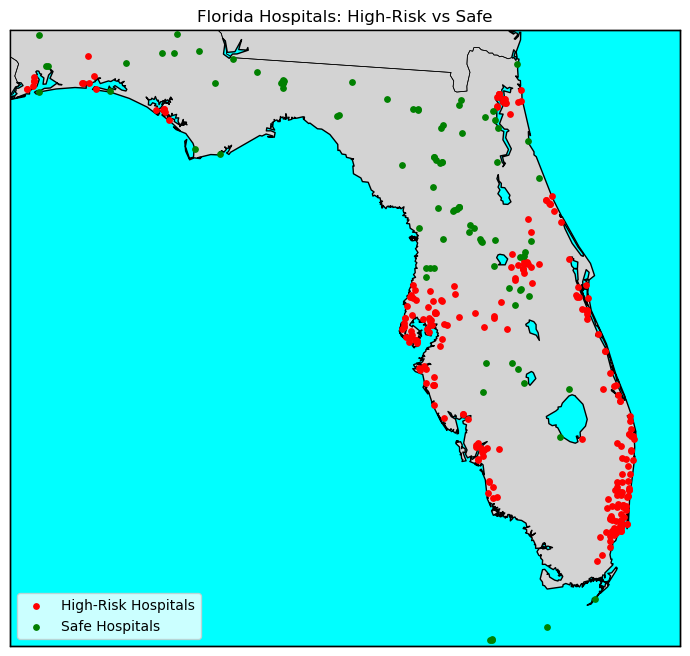

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Create a figure
plt.figure(figsize=(12, 8))

# Create a Basemap instance for Florida
m = Basemap(projection='merc', llcrnrlat=24.5, urcrnrlat=31.0,
            llcrnrlon=-87.5, urcrnrlon=-79.5, lat_ts=20, resolution='i')

# Draw coastlines, state boundaries, and fill continents
m.drawcoastlines()
m.drawstates()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# Convert latitude and longitude to map coordinates
x_risky, y_risky = m(risky_hospitals['X'].values, risky_hospitals['Y'].values)
x_safe, y_safe = m(safe_hospitals['X'].values, safe_hospitals['Y'].values)

# Plot the hospitals
plt.scatter(x_risky, y_risky, color='red', label='High-Risk Hospitals', s=15, zorder=5)
plt.scatter(x_safe, y_safe, color='green', label='Safe Hospitals', s=15, zorder=5)

plt.title('Florida Hospitals: High-Risk vs Safe')
plt.legend()
plt.show()

# Evacuation Routes between Hospitals:

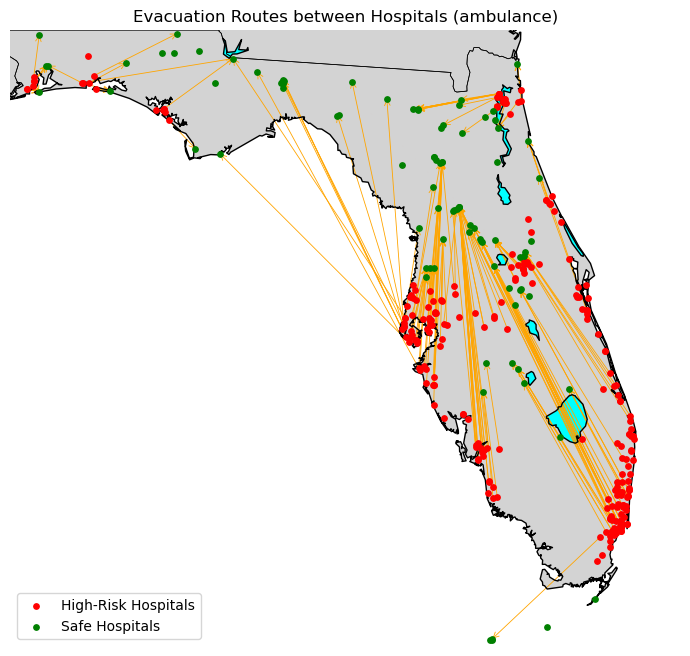

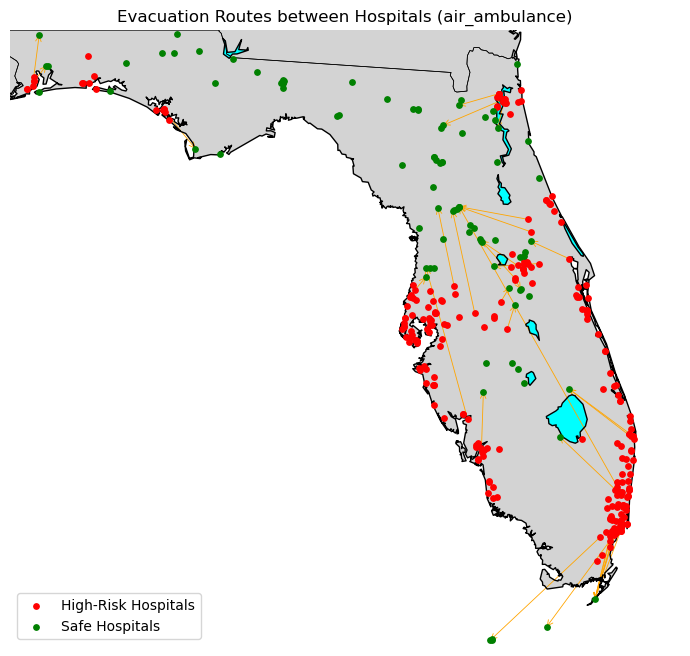

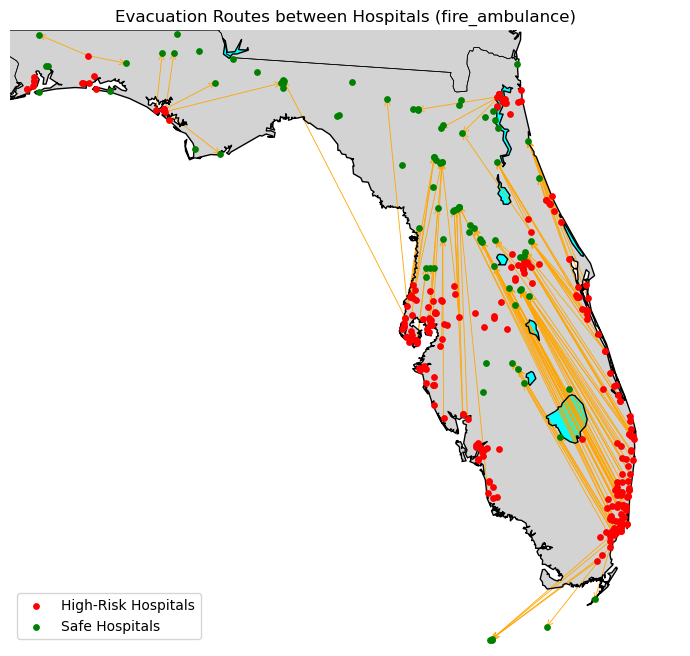

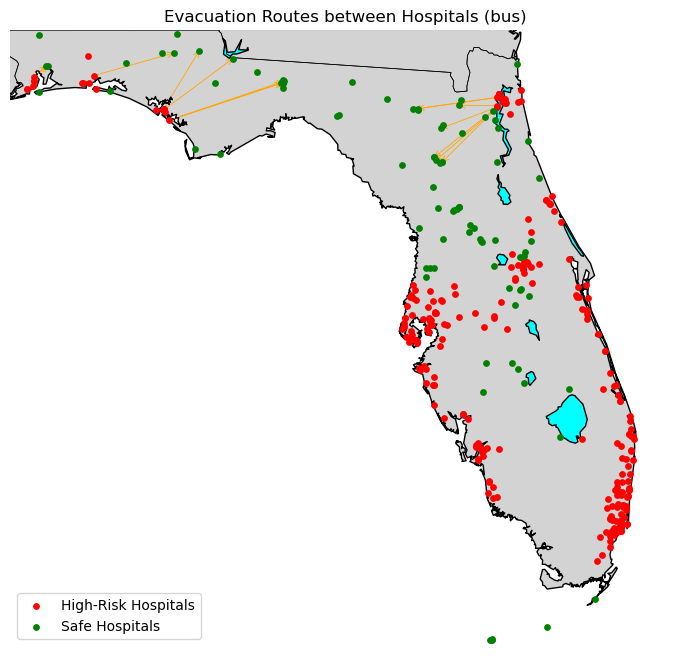

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Get the coordinates of the risky hospitals
coordinates_risky = risky_hospitals[['Name', 'X', 'Y']].set_index('Name').to_dict('index')

# Get the coordinates of the safe hospitals
coordinates_safe = safe_hospitals[['Name', 'X', 'Y']].set_index('Name').to_dict('index')

# Combine the coordinates
all_coordinates = coordinates_risky.copy()
all_coordinates.update(coordinates_safe)

# Create a separate graph for each vehicle type
for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
    G = nx.DiGraph()
    for r in range(len(risky_hospitals)):
        for s in range(len(safe_hospitals)):
            if z[r, s, v].x > 0:
                G.add_edge(risky_hospitals.iloc[r]['Name'], safe_hospitals.iloc[s]['Name'], weight=z[r, s, v].x)

    # Create a dictionary for node positions with latitude and longitude as coordinates
    pos = {hospital: (all_coordinates[hospital]['X'], all_coordinates[hospital]['Y']) for hospital in G.nodes}

    # Draw the graph with adjusted parameters and using pos for node positions
    plt.figure(figsize=(12, 8))

    # Create a Basemap instance for Florida
    m = Basemap(projection='merc', llcrnrlat=24.5, urcrnrlat=31.0,
                llcrnrlon=-87.5, urcrnrlon=-79.5, lat_ts=20, resolution='i')

    # Draw coastlines, state boundaries, and fill continents
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Convert lat/lon to map projection coordinates
    x, y = m([pos[node][0] for node in G.nodes()], [pos[node][1] for node in G.nodes()])
    pos_proj = dict(zip(G.nodes(), zip(x, y)))

    # Draw the graph
    nx.draw(G, pos_proj, with_labels=False, node_size=0, node_color='skyblue',edge_color='orange', width=0.6, arrows=True, arrowstyle='->', arrowsize=10)

    # Plot the hospitals
    x_risky, y_risky = m(risky_hospitals['X'].values, risky_hospitals['Y'].values)
    x_safe, y_safe = m(safe_hospitals['X'].values, safe_hospitals['Y'].values)
    plt.scatter(x_risky, y_risky, color='red', label='High-Risk Hospitals', s=15, zorder=5)
    plt.scatter(x_safe, y_safe, color='green', label='Safe Hospitals', s=15, zorder=5)

    plt.title(f'Evacuation Routes between Hospitals ({v_type})')
    plt.legend()
    plt.show()

# Table Results Summary:

In [29]:
from tabulate import tabulate

summary_data = [
    ['Total Patients Evacuated', int(total_evacuated_val)],
    ['Total Cost', f'${cost_obj.getValue():,.2f}'],
    ['Total Pollution', f'{pollution_obj.getValue():,.2f} pounds of CO2']
]

for v_type, total in vehicle_totals.items():
    summary_data.append([f'Patients Evacuated by {v_type.replace("_", " ").title()}', int(total)])

print(tabulate(summary_data, headers=['Metric', 'Value'], tablefmt='grid'))

+--------------------------------------+----------------------------+
| Metric                               | Value                      |
+======================================+============================+
| Total Patients Evacuated             | 4597                       |
+--------------------------------------+----------------------------+
| Total Cost                           | $756,560.07                |
+--------------------------------------+----------------------------+
| Total Pollution                      | 1,518,528.62 pounds of CO2 |
+--------------------------------------+----------------------------+
| Patients Evacuated by Ambulance      | 1609                       |
+--------------------------------------+----------------------------+
| Patients Evacuated by Air Ambulance  | 32                         |
+--------------------------------------+----------------------------+
| Patients Evacuated by Fire Ambulance | 1196                       |
+-------------------

# Number of Patients Evacuated by Vehicle Type:

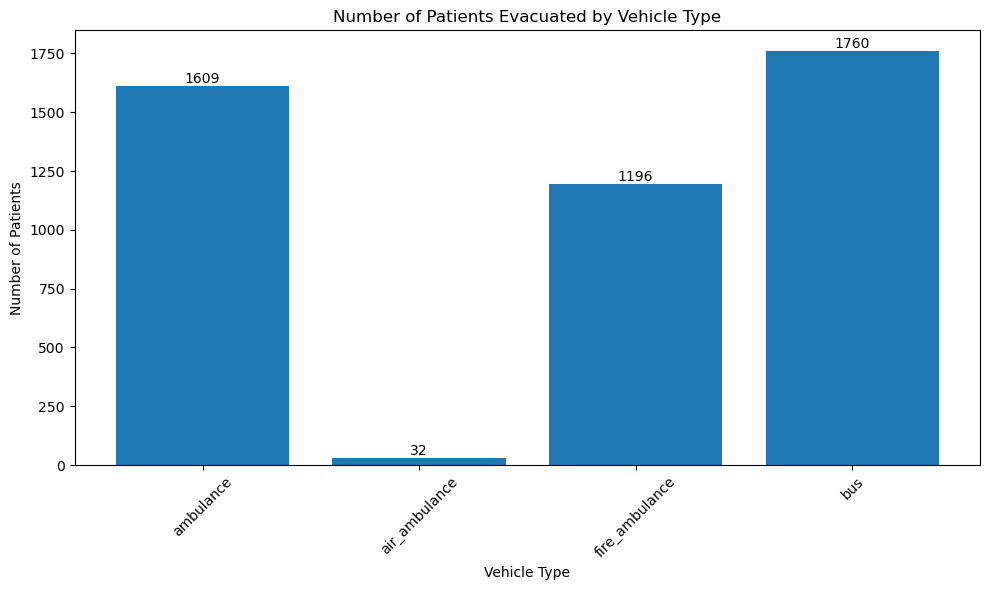

In [30]:
import matplotlib.pyplot as plt

vehicle_types = list(vehicle_totals.keys())
patients = [vehicle_totals[v] for v in vehicle_types]

plt.figure(figsize=(10, 6))
plt.bar(vehicle_types, patients)
plt.title('Number of Patients Evacuated by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
for i, v in enumerate(patients):
    plt.text(i, v, str(int(v)), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Evacuation Times Visualizations:

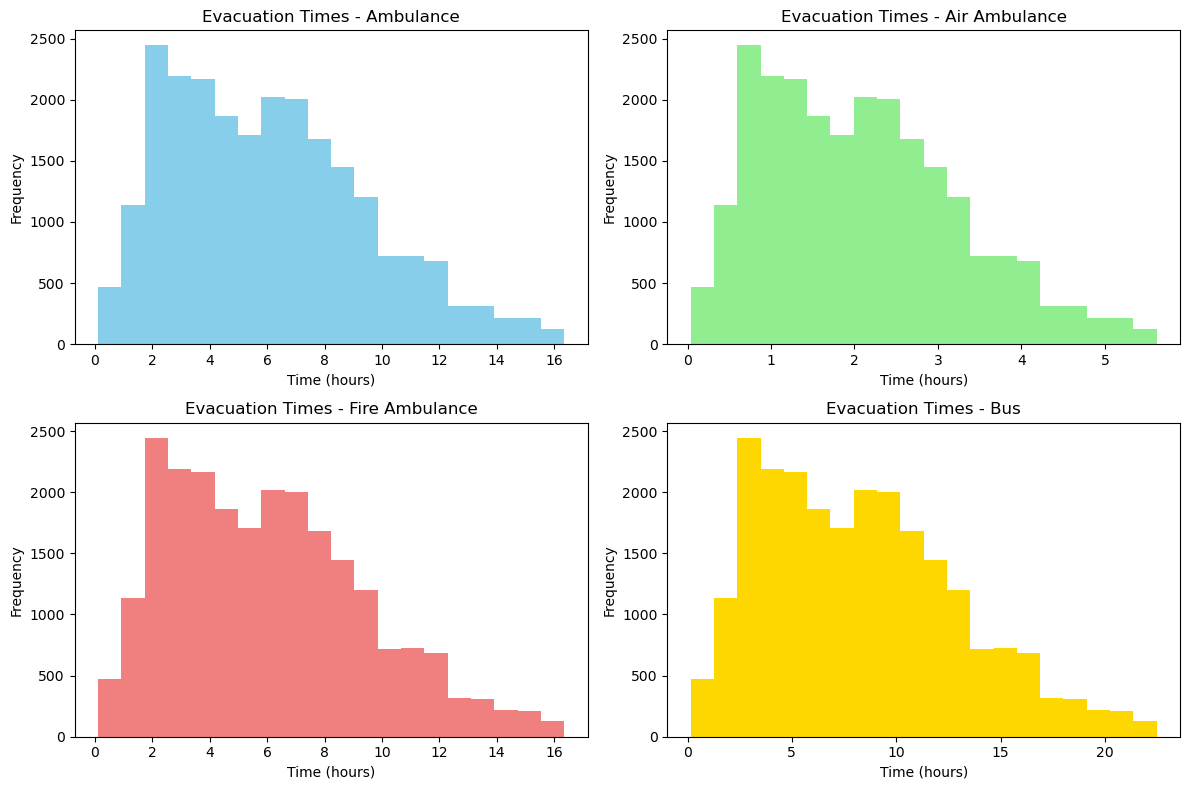

In [31]:
import matplotlib.pyplot as plt

# Flatten the time matrices and filter out zeros to create histograms
evac_times_ambulance = np.array(times_risky_safe['ambulance']).flatten()
evac_times_ambulance = evac_times_ambulance[evac_times_ambulance > 0]  # Remove zero values for a cleaner histogram

evac_times_air_ambulance = np.array(times_risky_safe['air_ambulance']).flatten()
evac_times_air_ambulance = evac_times_air_ambulance[evac_times_air_ambulance > 0]

evac_times_fire_ambulance = np.array(times_risky_safe['fire_ambulance']).flatten()
evac_times_fire_ambulance = evac_times_fire_ambulance[evac_times_fire_ambulance > 0]

evac_times_bus = np.array(times_risky_safe['bus']).flatten()
evac_times_bus = evac_times_bus[evac_times_bus > 0]

# Plot histograms for evacuation times (one subplot per vehicle type for better comparison)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0, 0].hist(evac_times_ambulance, bins=20, color='skyblue')
axes[0, 0].set_title('Evacuation Times - Ambulance')
axes[0, 0].set_xlabel('Time (hours)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(evac_times_air_ambulance, bins=20, color='lightgreen')
axes[0, 1].set_title('Evacuation Times - Air Ambulance')
axes[0, 1].set_xlabel('Time (hours)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(evac_times_fire_ambulance, bins=20, color='lightcoral')
axes[1, 0].set_title('Evacuation Times - Fire Ambulance')
axes[1, 0].set_xlabel('Time (hours)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(evac_times_bus, bins=20, color='gold')
axes[1, 1].set_title('Evacuation Times - Bus')
axes[1, 1].set_xlabel('Time (hours)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Proportion of Patients Evacuated by Vehicle Type:

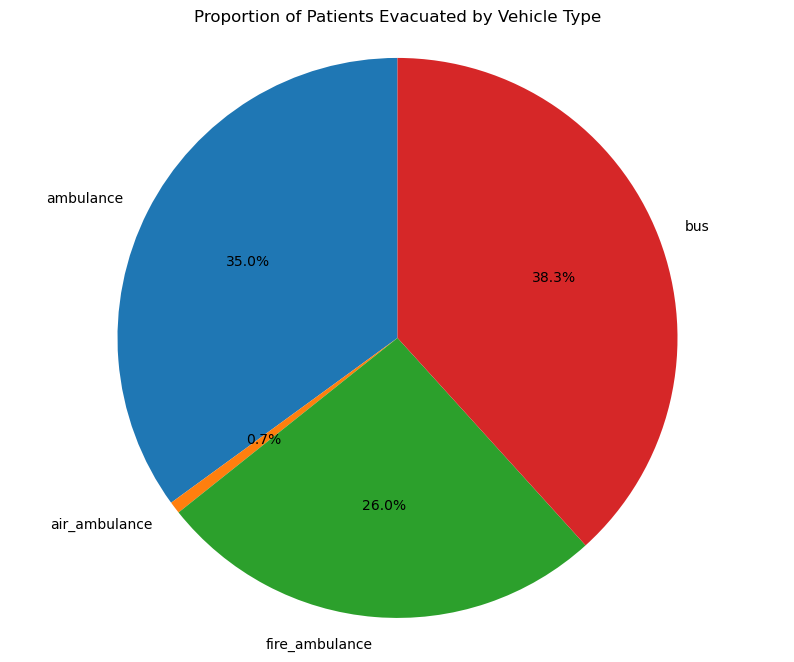

In [32]:
plt.figure(figsize=(10, 8))
plt.pie(patients, labels=vehicle_types, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Patients Evacuated by Vehicle Type')
plt.axis('equal')
plt.show()

# Top 10 EMS Stations by Number of Vehicles Dispatched:

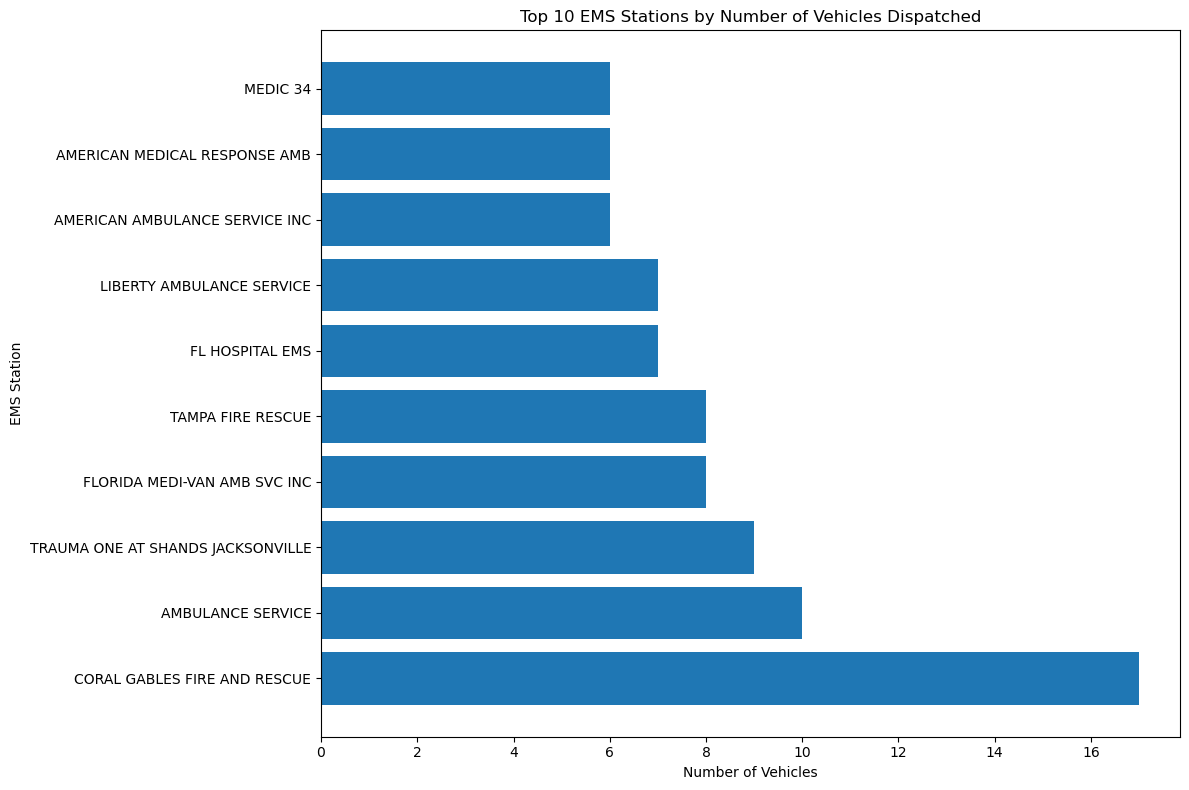

In [33]:
ems_vehicle_count = {}
for e in range(len(ems_data)):
    count = sum(u[e, r, v].x for r in range(len(risky_hospitals)) for v in range(len(VEHICLE_CAPACITIES)))
    ems_vehicle_count[ems_data.iloc[e]['Name']] = count

top_10_ems = dict(sorted(ems_vehicle_count.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(12, 8))
plt.barh(list(top_10_ems.keys()), list(top_10_ems.values()))
plt.title('Top 10 EMS Stations by Number of Vehicles Dispatched')
plt.xlabel('Number of Vehicles')
plt.ylabel('EMS Station')
plt.tight_layout()
plt.show()

# Vehicle Distribution for Top 10 Risky Hospitals:

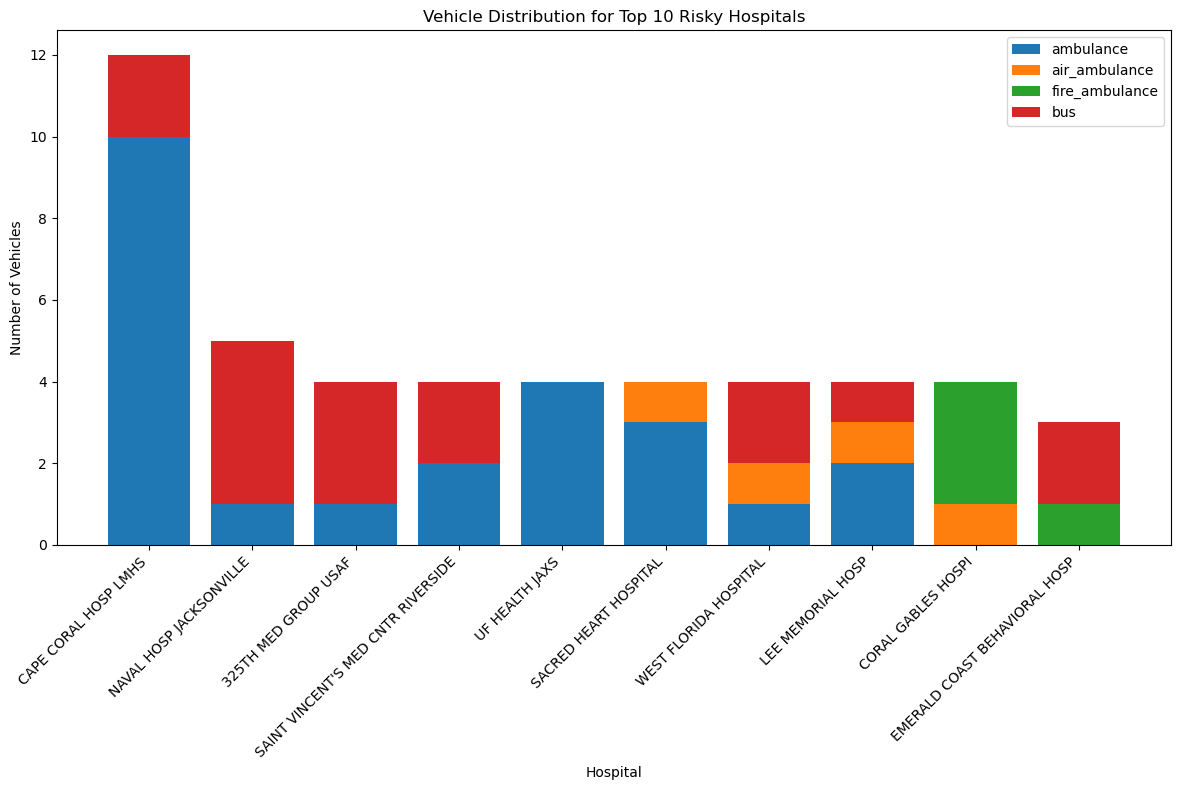

In [34]:
hospital_vehicle_count = {}
for r in range(len(risky_hospitals)):
    counts = [sum(u[e, r, v].x for e in range(len(ems_data))) for v in range(len(VEHICLE_CAPACITIES))]
    hospital_vehicle_count[risky_hospitals.iloc[r]['Name']] = counts

top_10_hospitals = dict(sorted(hospital_vehicle_count.items(), key=lambda x: sum(x[1]), reverse=True)[:10])

fig, ax = plt.subplots(figsize=(12, 8))
bottom = np.zeros(10)

for i, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
    values = [hospital_vehicle_count[hospital][i] for hospital in top_10_hospitals.keys()]
    ax.bar(list(top_10_hospitals.keys()), values, bottom=bottom, label=v_type)
    bottom += values

ax.set_title('Vehicle Distribution for Top 10 Risky Hospitals')
ax.set_xlabel('Hospital')
ax.set_ylabel('Number of Vehicles')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cost vs. Pollution vs. People Transported for Each Vehicle Type:

In [35]:
import plotly.graph_objects as go

vehicle_costs = {v_type: 0 for v_type in VEHICLE_CAPACITIES.keys()}
vehicle_pollution = {v_type: 0 for v_type in VEHICLE_CAPACITIES.keys()}
vehicle_people = {v_type: 0 for v_type in VEHICLE_CAPACITIES.keys()}

for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
            trips = z[r, s, v].x
            distance = distances_risky_safe[r, s]
            if v_type in ['ambulance', 'fire_ambulance', 'bus']:
                vehicle_costs[v_type] += (distance * 0.621371 / FUEL_EFFICIENCY[v_type] * FLORIDA_DIESEL_PRICE + 
                                          times_risky_safe[v_type][r, s] * (EMT_WAGE + PARAMEDIC_WAGE)) * trips * 2
                vehicle_pollution[v_type] += (distance * 0.621371 / FUEL_EFFICIENCY[v_type] * DIESEL_POLLUTION) * trips * 2
            else:  # air_ambulance
                vehicle_costs[v_type] += (times_risky_safe[v_type][r, s] * 
                                          (FUEL_EFFICIENCY[v_type] * FLORIDA_JET_FUEL_PRICE + PILOT_WAGE + PARAMEDIC_WAGE)) * trips * 2
                vehicle_pollution[v_type] += (times_risky_safe[v_type][r, s] * FUEL_EFFICIENCY[v_type] * JET_FUEL_POLLUTION) * trips * 2
            vehicle_people[v_type] += VEHICLE_CAPACITIES[v_type] * trips

fig = go.Figure()

for v_type in VEHICLE_CAPACITIES.keys():
    fig.add_trace(go.Scatter3d(
        x=[vehicle_costs[v_type]],
        y=[vehicle_pollution[v_type]],
        z=[vehicle_people[v_type]],
        mode='markers',
        name=v_type,
        marker=dict(
            size=10,
            opacity=0.8
        ),
        text=[f"{v_type}<br>Cost: ${vehicle_costs[v_type]:,.2f}<br>Pollution: {vehicle_pollution[v_type]:,.2f} lbs CO2<br>People: {vehicle_people[v_type]:,.0f}"],
        hoverinfo='text'
    ))

fig.update_layout(
    title='Cost vs. Pollution vs. People Transported for Each Vehicle Type',
    scene=dict(
        xaxis_title='Cost ($)',
        yaxis_title='Pollution (pounds of CO2)',
        zaxis_title='People Transported'
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

# Evacuation Routes Intensity:

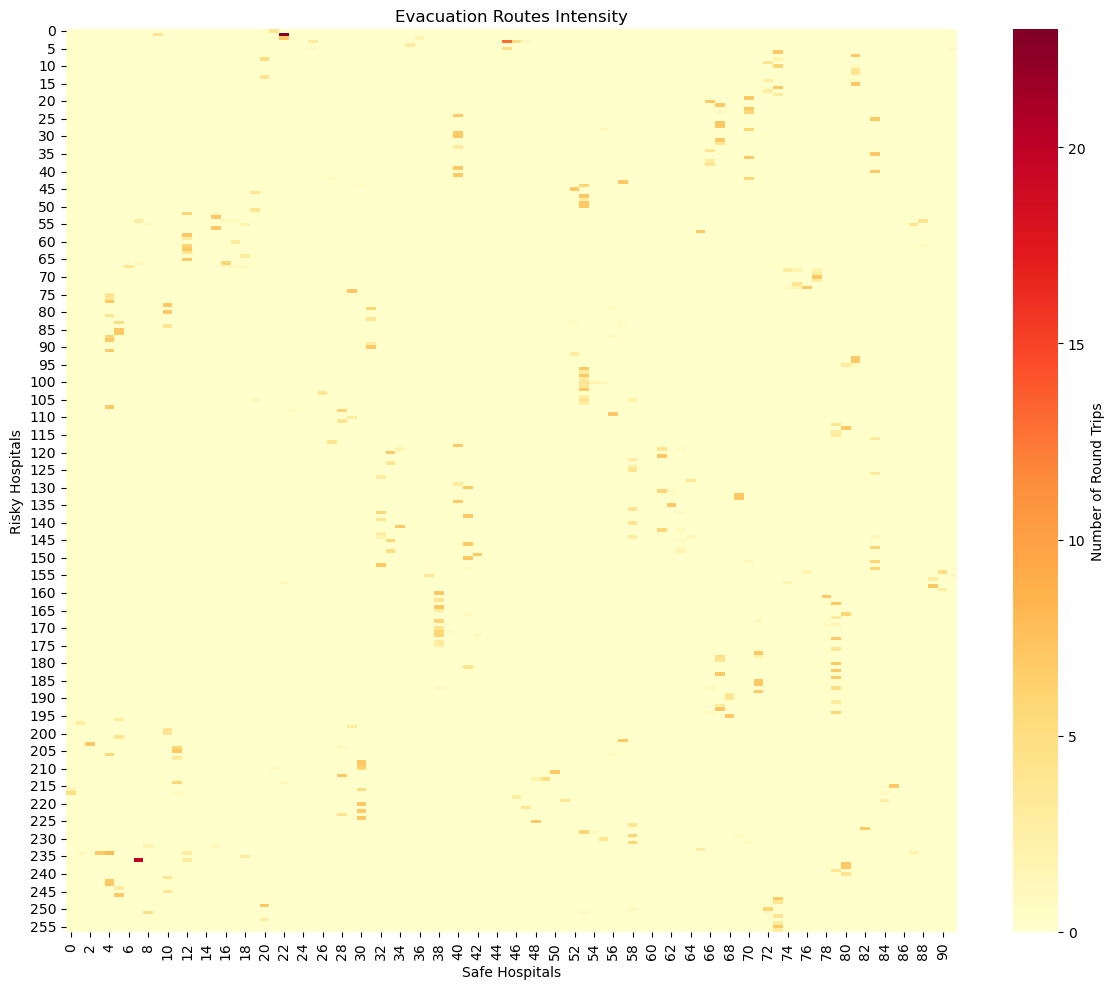

In [36]:
import seaborn as sns

evacuation_intensity = np.zeros((len(risky_hospitals), len(safe_hospitals)))
for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        evacuation_intensity[r, s] = sum(z[r, s, v].x for v in range(len(VEHICLE_CAPACITIES)))

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(evacuation_intensity, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Number of Round Trips'})
plt.title('Evacuation Routes Intensity')
plt.xlabel('Safe Hospitals')
plt.ylabel('Risky Hospitals')
plt.tight_layout()
plt.show()

# Cumulative Patient Evacuation Over Time:

In [37]:
import plotly.graph_objects as go
import numpy as np

# Assume evacuation takes place over 72 hours (3 days)
hours = np.arange(0, 73, 1)

# Calculate cumulative evacuation for each vehicle type over time
cumulative_evacuation = {v_type: [0] * len(hours) for v_type in VEHICLE_CAPACITIES.keys()}

for r in range(len(risky_hospitals)):
    for s in range(len(safe_hospitals)):
        for v, v_type in enumerate(VEHICLE_CAPACITIES.keys()):
            trips = z[r, s, v].x
            travel_time = times_risky_safe[v_type][r, s]
            patients_per_trip = VEHICLE_CAPACITIES[v_type]
            
            for trip in range(int(trips)):
                start_hour = int(trip * (travel_time * 2 + 0.5))  # Round trip + 30 min turnaround
                if start_hour < len(hours):
                    cumulative_evacuation[v_type][start_hour:] = [x + patients_per_trip for x in cumulative_evacuation[v_type][start_hour:]]

# Create stacked area chart
fig = go.Figure()

for v_type in VEHICLE_CAPACITIES.keys():
    fig.add_trace(go.Scatter(
        x=hours,
        y=cumulative_evacuation[v_type],
        mode='lines',
        stackgroup='one',
        name=v_type.replace('_', ' ').title()
    ))

fig.update_layout(
    title='Cumulative Patient Evacuation Over Time',
    xaxis_title='Hours',
    yaxis_title='Cumulative Patients Evacuated',
    legend_title='Vehicle Type'
)

fig.show()